In [3]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from matplotlib import pyplot as plt
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils
from mrcnn import visualize
import surgery
import random
from glob import glob

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs

PRETRAINED_MODEL_PATH = "/home/simon/logs/surgery_200/mask_rcnn_surgery_0030.h5"
IMAGE_DIR = "/home/simon/deeplearning/mask_rcnn/data/surgery/predict"

In [4]:
class InferenceConfig(surgery.SurgeryConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
config = InferenceConfig()
config.display()

model = modellib.MaskRCNN(mode="inference", config=config, model_dir='/home/simon/logs/surgery_200')
model_path = PRETRAINED_MODEL_PATH
# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

# Prediction and merge masks 

In [5]:
file_names = glob(os.path.join(IMAGE_DIR, "*.jpg"))
masks_prediction = np.zeros((1200, 1600, len(file_names)))
for i in range(len(file_names)):
    print(i)
    image = skimage.io.imread(file_names[i])
    predictions = model.detect([image],  verbose=1)
    p = predictions[0]
    masks = p['masks']
    merged_mask = np.zeros((masks.shape[0], masks.shape[1]))
    for j in range(masks.shape[2]):
        merged_mask[masks[:,:,j]==True] = True
        masks_prediction[:,:,i] = merged_mask
print(masks_prediction.shape)

0
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
2
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max: 

21
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
22
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
23
Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  ma

# Load Annotations

In [6]:
PREDICT_DIR = '/home/simon/deeplearning/mask_rcnn/data/surgery/'
dataset = surgery.SurgeryDataset()
dataset.load_VIA(PREDICT_DIR, 'predict')

# Calculate Accuracy 

In [7]:
accuracy = 0
precision = 0
for image_id in range(len(dataset.image_info)):
    name = dataset.image_info[image_id]['id']
    file_name = os.path.join(IMAGE_DIR, name)
    image_id_pred = file_names.index(file_name)
    merged_mask = masks_prediction[:, :, image_id_pred]
    
    annotated_mask = dataset.load_mask(image_id)[0]
    merged_annotated_mask = np.zeros((1200, 1600))
    for i in range(annotated_mask.shape[2]):
        merged_annotated_mask[annotated_mask[:,:,i]==True] = True
    accuracy  += np.sum(merged_mask==merged_annotated_mask) / (1200 * 1600)
    all_correct = np.sum(merged_annotated_mask[merged_mask == 1])
    precision += all_correct / (np.sum(merged_mask))
print('accuracy:{}'.format(accuracy / len(file_names)))
print('precision:{}'.format(precision / len(file_names)))

accuracy:0.9953782852564106
precision:0.9678031185687436


# Trained with 100 images
Accuracy: 99.49%
Precision:97.02%
# Trained with 200 images
Accuracy: 99.54%
Precision: 96.78%
# Trained with 200 images(60 epochs)
Accuracy: 99.53%
Precision: 97.28%

# Visualize Random IMage

Processing 1 images
image                    shape: (1200, 1600, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1600.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


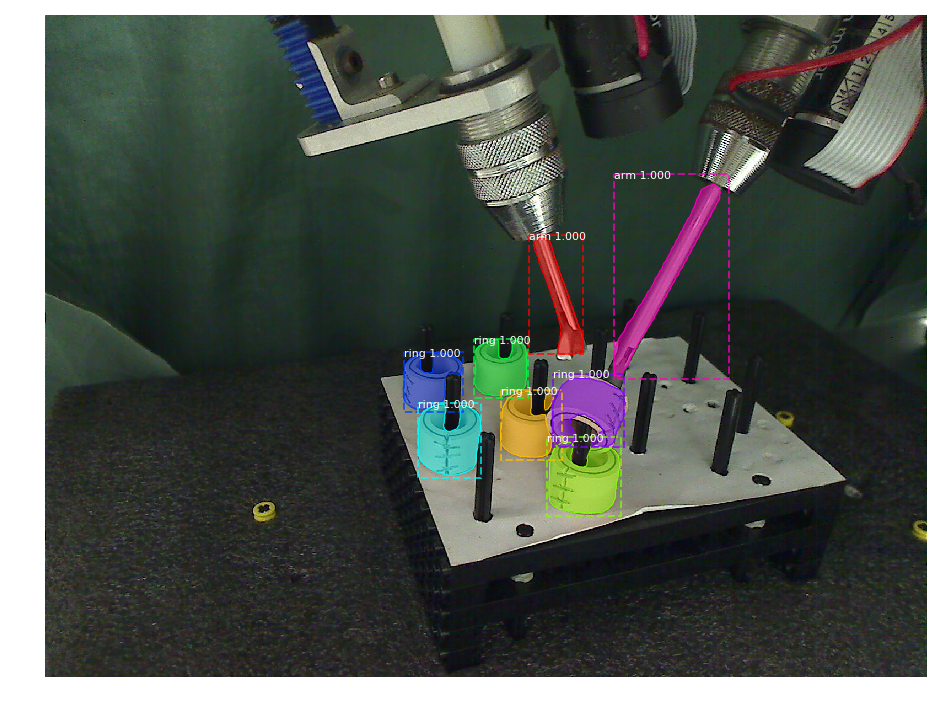

In [8]:
file_names = glob(os.path.join(IMAGE_DIR, "*.jpg"))
class_names = ['BG', 'arm', 'ring']
test_image = skimage.io.imread(file_names[random.randint(0,len(file_names)-1)])
predictions = model.detect([test_image], verbose=1) # We are replicating the same image to fill up the batch_size
p = predictions[0]
visualize.display_instances(test_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])